In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk

In [2]:
row_X = pd.read_csv('.\\articles_ko.csv', encoding='utf-8', sep=',')
row_y = pd.read_csv('.\\label_ko.csv', encoding='utf-8', sep=',')

In [3]:
tokenizer = Okt()

In [4]:
words = []
for title in row_X.title:
    tokens = tokenizer.morphs(title, norm=True, stem=True)
    words += tokens

In [5]:
text = nltk.Text(words, name='NMSC')

In [6]:
word_to_idx = {}
for text, _ in text.vocab().most_common(5000):
    word_to_idx[text] = len(word_to_idx) + 1

In [7]:
X = []
for title in row_X.title:
    tokens = tokenizer.morphs(title, norm=True, stem=True)
    raw = []
    for token in tokens:
        num = word_to_idx[token] if token in word_to_idx else 0
        raw.append(num)
    if len(raw) < 50:
        raw += [0] * (50 - len(raw))
    else:
        raw = raw[:50]
    X.append(raw)

In [8]:
X = np.array(X)

In [9]:
row_y.loc[row_y.updown == False, 'updown'] = 0
row_y.loc[row_y.updown == True, 'updown'] = 1
row_y.fillna(1, inplace=True)

In [10]:
y = row_y.updown
y = to_categorical(y)

In [11]:
model = Sequential([
    layers.Embedding(5001, 64),
    layers.LSTM(64, activation='tanh'),
    layers.Dense(2, activation='softmax')
])

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model_ko.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat(10).shuffle(10).batch(10)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).repeat(10).shuffle(10).batch(10)

In [17]:
hist = model.fit(train_dataset, epochs=30, callbacks=[es, mc], validation_data=val_dataset)

Train for 6813 steps, validate for 758 steps
Epoch 1/30
6809/6813 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5624
Epoch 00001: val_accuracy improved from -inf to 0.54881, saving model to best_model_ko.h5
6813/6813 [==============================] - 55s 8ms/step - loss: 0.6857 - accuracy: 0.5623 - val_loss: 0.6884 - val_accuracy: 0.5488
Epoch 2/30
6806/6813 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.5760
Epoch 00002: val_accuracy improved from 0.54881 to 0.58047, saving model to best_model_ko.h5
6813/6813 [==============================] - 53s 8ms/step - loss: 0.6768 - accuracy: 0.5762 - val_loss: 0.8450 - val_accuracy: 0.5805
Epoch 3/30
6811/6813 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.8852
Epoch 00003: val_accuracy did not improve from 0.58047
6813/6813 [==============================] - 54s 8ms/step - loss: 0.2721 - accuracy: 0.8852 - val_loss: 2.0841 - val_accuracy: 0.5620
Epoch 4/30
6807/6813 

In [18]:
from tensorflow.keras.models import load_model

In [19]:
loaded_model = load_model('.\\best_model_ko.h5')
print()
print(f'Test Accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}')


1893/1893 [==============================] - 1s 302us/sample - loss: 2.7735 - accuracy: 0.5679
Test Accuracy: 0.5679


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

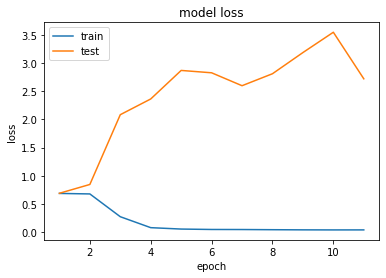

In [21]:
epochs = range(1, len(hist.history['accuracy']) + 1)
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()